# Component Demonstration Notebook

A notebook to demonstrate some of the features of the Component class

Author: gavin.treseder@essentialenergy.com.au

In [1]:
#  Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np 
import pandas as pd

import plotly.express as px

from pof.component import Component

In [2]:
comp = Component().set_demo()

In [3]:
comp.mc_timeline(t_end=100, n_iterations=100)

100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


In [4]:
def update_pof_figure2():

    pof = dict(
        untreated = pd.DataFrame(comp.expected_untreated(t_end=200)),
        treated = pd.DataFrame(comp.expected_pof(t_end=200)),
    )

    df = pd.concat(pof).rename_axis(['strategy', 'time']).reset_index()
    df = df.melt(id_vars = ['time', 'strategy'], var_name='source', value_name='pof')

    fig = px.line(df,x='time', y='pof', color='source', line_dash = 'strategy', line_group='strategy')
    return fig

update_pof_figure2().show()

def update_pof_figure():
    pof = comp.expected_pof(t_end=200)

    df = pd.DataFrame(pof)
    df.index.name = 'time'
    df = df.reset_index().melt(id_vars = 'time', var_name='source', value_name='pof')

    fig = px.line(df,x='time', y='pof', color='source', line_dash = 'source')
    return fig

update_pof_figure().show()

In [5]:
def expected_inspection_interval(x_min, x_max, n_iterations=100):
    rc = dict()
    comp.reset()

    for i in range(max(1, x_min),x_max,1):

        # Set t_interval
        for fm in comp.fm.values():
            if 'inspection' in list(fm.tasks):
                fm.tasks['inspection'].t_interval = i
        
        comp.mc_timeline(t_end=100, n_iterations=n_iterations)

        rc[i] = comp.expected_risk_cost_df().groupby(by=['task'])['cost'].sum()
        rc[i]['inspection_interval'] = i

        # Reset component
        comp.reset()

    df = pd.DataFrame().from_dict(rc, orient='index')
    df['total_cost'] = df.drop(['inspection_interval', 'risk'], axis=1).sum(axis=1)
    df['total'] = df['total_cost'] + df['risk']
    
    return df

df = expected_inspection_interval(0, 10)

100%|██████████| 100/100 [00:02<00:00, 41.48it/s]


In [6]:

def update_inspection_interval_figure():
    
    df = expected_inspection_interval(0,10)
    df_plot = df.melt(id_vars='inspection_interval', var_name = 'source', value_name='cost')
    fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
    return fig

update_inspection_interval_figure().show()

100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


In [7]:
n_iterations = 1000
t_min = 0
t_max = 10
scen = dict()

comp= Component().set_demo()

df_mean = expected_inspection_interval(0, 10, 1000)

comp= Component().set_demo()

for fm in comp.fm.values():
    fm.cof.risk_cost_total = 12000

df_low_c = expected_inspection_interval(0, 10, 1000)

comp= Component().set_demo()

for fm in comp.fm.values():
    fm.cof.risk_cost_total = 120000

df_high_c = expected_inspection_interval(0, 10, 1000)

comp= Component().set_demo()

for fm in comp.fm.values():
    fm.untreated.alpha = fm.untreated.alpha * 2
    fm.calc_init_dist()

df_low_pof = expected_inspection_interval(0, 10, 1000)

comp= Component().set_demo()

for fm in comp.fm.values():
    fm.untreated.alpha = fm.untreated.alpha / 2
    fm.calc_init_dist()

df_high_pof = expected_inspection_interval(0, 10, 1000)

100%|██████████| 1000/1000 [00:11<00:00, 88.50it/s]


In [8]:
    df_plot = df_low_pof.melt(id_vars='inspection_interval', var_name = 'source', value_name='cost')
    fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
    fig.show()

In [128]:
df_all = pd.concat(dict(
    mean = df_mean,
    high_c = df_high_c,
    low_c = df_low_c,
    low_pof = df_low_pof,
    high_pof = df_high_pof,
), ignore_index=False).reset_index()

df_all = df_all.rename(columns = {'level_0':'scenario'})

df_all['value_lost'] = (df_all['total'] - df_all.groupby(by = ['scenario'])['total'].transform('min'))/100 # time considered

df_plot = df_all#df_all.melt(id_vars='inspection_interval', var_name = 'source', value_name='cost')
fig = px.line(df_plot, x="inspection_interval", y="value_lost", color='scenario', title='Risk v Cost at different Inspection Intervals', color_discrete_sequence=px.colors.qualitative.Vivid)
fig.show()

In [66]:
filename = r"C:\Users\gtreseder\OneDrive - KPMG\Documents\3. Client\Essential Energy\Probability of Failure Model\ACS - Poles - Consequences 2.csv"
df_poles = pd.read_csv(filename)


In [190]:
depots = ['Young Depot', 'Temora Depot', 'Yass Depot', 'Young Depot', 'Bathurst Depot']

<AxesSubplot:ylabel='Depot (ZSG Area)'>

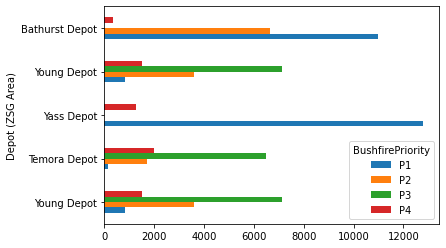

In [191]:

bushfire = df_poles.pivot_table(index='Depot (ZSG Area)', columns= 'BushfirePriority', values = 'ASSET_ID', aggfunc=len).fillna(0).astype(int)
bushfire.loc[depots].plot(kind='barh')

In [192]:
bushfire.loc[(bushfire != 0).all(axis=1)]

BushfirePriority,P1,P2,P3,P4
Depot (ZSG Area),,,,
Bulahdelah Depot,135,2404,4531,981
Griffith Depot,327,10682,2286,4387
Temora Depot,136,1719,6500,1989
Young Depot,816,3597,7123,1533
[ Deleted Assets ],22,266,83,39


In [193]:
bushfire = bushfire.reset_index().melt(id_vars='Depot (ZSG Area)', value_name='population')
bushfire.head()

,Depot (ZSG Area),BushfirePriority,population
0,Albury Depot,P1,2065
1,Armidale Depot,P1,0
2,Ballina Depot,P1,0
3,Balranald Depot,P1,0
4,Barham Depot,P1,0


In [194]:
df_bushfire = df_all.loc[df_all['scenario'].isin(['high_c', 'low_c']), ['scenario', 'inspection_interval', 'value_lost']]

In [195]:
df_bushfire['key'] = 0
bushfire['key'] = 0

jt = bushfire.merge(df_bushfire, on='key', how='outer')
jt.head()

,Depot (ZSG Area),BushfirePriority,population,key,scenario,inspection_interval,value_lost
0,Albury Depot,P1,2065,0,high_c,1,71.35
1,Albury Depot,P1,2065,0,high_c,2,0.00
2,Albury Depot,P1,2065,0,high_c,3,10.59
3,Albury Depot,P1,2065,0,high_c,4,79.56
4,Albury Depot,P1,2065,0,high_c,5,265.90


In [196]:
jt['total_value_lost'] = (jt.population * jt.value_lost).where((jt.BushfirePriority == 'P1') & (jt.scenario == 'high_c')).fillna(0)
jt['total_value_lost'] = jt['total_value_lost'] + (jt.population * jt.value_lost).where((jt.BushfirePriority != 'P1') & (jt.scenario == 'low_c')).fillna(0)
jt.head()

,Depot (ZSG Area),BushfirePriority,population,key,scenario,inspection_interval,value_lost,total_value_lost
0,Albury Depot,P1,2065,0,high_c,1,71.35,147337.75
1,Albury Depot,P1,2065,0,high_c,2,0.00,0.00
2,Albury Depot,P1,2065,0,high_c,3,10.59,21868.35
3,Albury Depot,P1,2065,0,high_c,4,79.56,164291.40
4,Albury Depot,P1,2065,0,high_c,5,265.90,549083.50


In [197]:
rh = jt.groupby(by=['Depot (ZSG Area)', 'inspection_interval'])['total_value_lost'].sum().reset_index()

In [198]:
rh = rh.loc[rh['Depot (ZSG Area)'].isin(depots)]

fig = px.line(
    rh,
    x="inspection_interval",
    y="total_value_lost",
    color="Depot (ZSG Area)",
    title= 'Optimum Inspection Interval by Depot'
)
fig

In [199]:
rh.groupby(by=['Depot (ZSG Area)']).min()

,inspection_interval,total_value_lost
Depot (ZSG Area),,
Bathurst Depot,1,129291.74
Temora Depot,1,10820.16
Yass Depot,1,29534.58
Young Depot,1,31309.49


In [51]:
fig = px.area(
    df,
    x="time",
    y="cost_cumulative",
    color="task",
    line_group = 'failure_mode'
)
fig

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['immediate_replacement', 'inspection', 'on_condition_repair', 'on_condition_replacement', 'risk', 'inspection_interval', 'total_cost', 'total'] but received: time

101

In [112]:
comp.mc_timeline(200, n_iterations=1000)

100%|██████████| 1000/1000 [00:25<00:00, 39.15it/s]


In [113]:

import plotly.graph_objects as go


def update_condition_fig(*args):
    """ Updates the condition figure"""

    fig = go.Figure()

    ecl = comp.expected_condition_loss()

    cmap = px.colors.qualitative.Safe
    ci = 0

    for cond_name, cond in ecl.items():
        # Format the data for plotting
        length = len(cond['mean'])
        time = np.linspace(0,length  -1, length, dtype=int) # TODO take time as a variable
        x = np.append(time,time[::-1])
        y = np.append(cond['upper'], cond['lower'][::-1])

        # Add the boundary
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            fill='toself',
            fillcolor='rgba' + cmap[ci][3:-2] + ',0.2)',
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=cond_name,
        ))
        fig.add_trace(go.Scatter(
            x=time, y=cond['mean'],
            line_color=cmap[ci],
            name=cond_name,
        ))

        ci = ci + 1

        fig.update_traces(mode='lines')
        fig.update_xaxes(title_text='Time')
        fig.update_yaxes(title_text='Condition (%)')

    return fig


fig = update_condition_fig()
fig.show()

In [11]:
fm = comp.fm['random']
stdev = 1

expected = dict()
for cond_name, condition in fm.conditions.items():

    ec = np.array([fm._timelines[x][cond_name] for x in fm._timelines])

    mean = condition.perfect - ec.mean(axis=0)
    sd = ec.std(axis=0)
    upper = mean + sd*stdev
    lower = mean - sd*stdev

    upper[upper > condition.perfect] = condition.perfect
    lower[lower < condition.failed] = condition.failed

    expected[cond_name] = dict(
        lower=lower,
        mean=mean,
        upper=upper,
        sd=sd,
            )

TypeError: 'numpy.float64' object does not support item assignment

In [18]:
fm.timeline

{}

In [13]:
n_time = 1001
time = list(np.linspace(0,n_time - 1, n_time))

failure_modes = []
tasks = []
times = []
costs = []
cumulative_costs = []

n_fm = len(erc)

for fm, fm_values in erc.items():

    for task, task_values in fm_values.items():
        failure_mode = np.full(n_time, fm)
        task = np.full(n_time, task)
        cost = np.full(n_time, 0)
        cost[task_values['time']] = task_values['cost']
        cumulative_cost = cost.cumsum()

        failure_modes = np.append(failure_modes, failure_mode)
        tasks = np.append(tasks, task)
        costs = np.append(costs, cost)
        times = np.append(times, time)
        cumulative_costs = np.append(cumulative_costs, cumulative_cost)


df = pd.DataFrame(
    dict(
        failure_mode=failure_modes,
        task=tasks,
        time=times,
        cost=costs,
        cumulative_cost=cumulative_costs,
    )
)

IndexError: arrays used as indices must be of integer (or boolean) type

In [14]:
times = np.linspace(0,100,101, dtype=int)
n=101

time = np.array(df['time'].values.tolist())
cost = np.array(df['cost'].values.tolist())
fmt = np.repeat(df[['failure_mode', 'task']].to_numpy(),n, axis=0)
pd.DataFrame(np.column_stack((a, vals.ravel())), columns=df.columns)

NameError: name 'a' is not defined

In [15]:
profile = comp.fm['random'].expected_cost()
profile['risk'] = comp.fm['random'].expected_risk()

AttributeError: 'FailureMode' object has no attribute 'expected_cost'

In [16]:
%timeit comp.fm['slow_aging'].expected_cost_df()

27.6 ms ± 9.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit comp.fm['slow_aging'].expected_risk_cost_df()

3.79 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
rc = comp.fm['slow_aging'].expected_risk_cost()

In [19]:
new_index = pd.Index(np.arange(0, 200, 1), name="time")

t = rc['inspection']['time']
c = rc['inspection']['cost']

In [20]:
tc = dict(task=[], time=[], cost=[])

for k, v in rc.items():
    tc['task'] = np.append(tc['task'], np.full(len(v['time']), k))
    for m in ['time', 'cost']:
        time = tc[m]
        
        

        tc[m] = np.append(tc[m], v[m])

array([ 0. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. , 49.5])

In [21]:
df = comp.fm['random'].expected_risk_cost_df()
df.index.name = 'task'
df = df.reset_index()

In [22]:
df = comp.fm['slow_aging'].expected_risk_cost_df()

In [23]:

px.line(
    df.reset_index(),
    x="time",
    y="cumulative_cost",
    color="task",
    line_group =
)

SyntaxError: invalid syntax (<ipython-input-23-cdf092dcd93a>, line 7)